C:\Users\Administrator\AppData\Local\Temp\ipykernel_43944\479886591.py:101: DeprecationWarning: Please use atoms.cell.cellpar() instead
  lattice = p1.get_cell_lengths_and_angles()[:3]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_43944\479886591.py:102: DeprecationWarning: Please use atoms.cell.cellpar() instead
  angle = p1.get_cell_lengths_and_angles()[3:]


结构0--EV曲线生成的结构数量为: 4
结构0:EV曲线生成的结构数量为: 2000
结构0:MD模拟生成的结构数量为: 4040


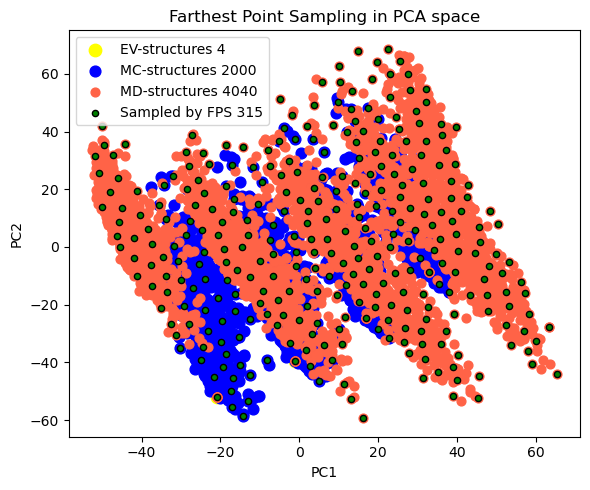

In [90]:
from ase.build import bulk
from ase.io import read, write
from hiphive.structure_generation import (generate_mc_rattled_structures)
import numpy as np 
from dscribe.descriptors import SOAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pynep.calculate import NEP
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.nvtberendsen import NVTBerendsen
from ase import units

def md_sampling(initial_atoms, steps, interval,T):
    """
    initial_atoms: MD初始结构
    steps: MD总步数
    interval: 采样间隔  
    T: 模拟的温度列表
    """

    atoms = initial_atoms.copy()
    atoms.calc = NEP("nep_universal.txt")
    snaps = []
    for t in T:
        MaxwellBoltzmannDistribution(atoms, temperature_K=t)
        dyn = NVTBerendsen(atoms, 2 * units.fs, temperature=t, taut=0.5*1000*units.fs)
        # dyn = NPTBerendsen(atoms=atoms, timestep=2 * units.fs, temperature_K=T, taut=0.5*1000*units.fs, pressure_au=1.01325 * units.bar, taup=1000 * units.fs, compressibility_au=4.57e-5 / units.bar)
        
        dyn.attach(lambda a=atoms: snaps.append(a.copy()), interval=interval)
        dyn.run(steps)
    return snaps

def fps_with_threshold(X, r_min):
    """
    最远点采样，无需预设数量。只要新点与已有采样点距离 > r_min 就加入。
    X: (N, D) 特征向量
    r_min: 最小允许距离阈值
    返回值: 采样点索引列表
    """
    N = X.shape[0]
    selected = [np.random.randint(N)]  # 随机选第一个
    for i in range(N):
        if i in selected:
            continue
        dists = np.linalg.norm(X[i] - X[selected], axis=1)
        if np.all(dists > r_min):
            selected.append(i)
    return selected

def FPS_sampling(structures,fout,EV_idnex,MC_index,MD_index):
    """
    structures: 结构列表 ASE    
    fout: 输出的最终数据集  
    EV_index: 统计的EV曲线采样结构数目  
    MC_index: MC 随机采样结构数目   
    MD_index: MD 分子动力学采样结构数目 
    """
    species = list(set(atom.symbol  for atom in structures[0]))
    r_cut = 8
    n_max = 8
    l_max = 6 
    soap = SOAP(species=species,periodic=True,r_cut=r_cut,n_max=n_max,l_max=l_max)
    soap_features = []
    for atoms in structures:
        desc = soap.create(atoms)         # 每个原子的 SOAP
        avg_desc = desc.mean(axis=0)      # 平均化为结构级特征
        soap_features.append(avg_desc)
    soap_features = np.array(soap_features)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(soap_features)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    r_min = 4  
    selected_indices = fps_with_threshold(X_pca, r_min)
    sampled_structures = [structures[i] for i in selected_indices]
    from ase.io import write
    write(fout, sampled_structures)
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:EV_idnex, 0], X_pca[:EV_idnex, 1], c='yellow', s=80, label=f'EV-structures {EV_idnex}')
    plt.scatter(X_pca[EV_idnex:EV_idnex+MC_index, 0], X_pca[EV_idnex:EV_idnex+MC_index, 1], c='blue', s=60, label=f'MC-structures {MC_index}')
    plt.scatter(X_pca[EV_idnex+MC_index:, 0], X_pca[EV_idnex+MC_index:, 1], c='tomato', s=40, label=f'MD-structures {MD_index}')
    X_sampled = X_pca[selected_indices]
    plt.scatter(X_sampled[:, 0], X_sampled[:, 1], c='green', s=20, edgecolors='black', label=f'Sampled by FPS {len(selected_indices)}')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Farthest Point Sampling in PCA space")
    plt.legend()
    plt.tight_layout()
    plt.show()


# E-V 曲线结构
def rescale_volume(p1,min,max,bin):
    """
    p1: 采样的基态结构.     
    min: 最小体积比.    
    max: 最大体积比.    
    bin: 撒点间隔.  
    """
    lattice = p1.get_cell_lengths_and_angles()[:3]
    angle = p1.get_cell_lengths_and_angles()[3:]
    rescale_latt_list = []
    for i in range(min,max,bin):
        l_new = lattice+lattice*i/100
        p_temp = p1.copy()
        new_cell = np.concatenate((l_new, angle))
        p_temp.set_cell(new_cell,scale_atoms=True)
        rescale_latt_list.append(p_temp)
    return rescale_latt_list

# MC 随机微扰结构  好用！！！！
def MC_rattled(p1,size,n_structures,rattle_std,min_distance,iter):
    """
    p1: 采样的基态结构.     
    size: 扩胞比例.    
    nstructures: 采样的结构数.    
    rattle_std: 采样的标准差.   
    min_distance: 最小位移距离.     
    iter: 蒙特卡洛循环数.   
    """
    supercell = p1.repeat(size)
    structures_mc_rattle = generate_mc_rattled_structures(
        supercell, n_structures, 0.25*rattle_std, min_distance, n_iter=iter)
    return structures_mc_rattle

def generate_MC_dataset(p1,MC_cycle):
    RMC_list = MC_rattled(p1,1,100,0.15,0.01,MC_cycle)
    return RMC_list

def generate_EV_dataset(p1):
    EV_list = rescale_volume(p1,-4,4,2)
    return EV_list

def generate_train_dataset(phase_list,save_path,T):
    for k in range(len(phase_list)):
        p1 = read(phase_list[k])
        EV = generate_EV_dataset(p1)
        EV_number = len(EV)
        
        MC_list = []
        MD_list = []
        for s in range(len(EV)):
            for i in range(10,100,20):
                MD = md_sampling(EV[s], 10000, 100,T)
                MC = generate_MC_dataset(EV[s],i)
                MC_list += MC
                MD_list += MD
        print(f"结构{k}--EV曲线生成的结构数量为:",EV_number)
        print(f"结构{k}--MC微扰生成的结构数量为:",len(MC_list))
        print(f"结构{k}--MD模拟生成的结构数量为:",len(MD_list))
        FPS_sampling(EV+MC_list+MD_list,save_path+f"\\mc_rattle_{k}.extxyz",len(EV),len(MC_list),len(MD_list))

save_path = r"C:\Users\Administrator\Desktop"  ## 轨迹保存的路径
phase_list = [r"E:\课题2-成核模拟\CsPbI3\MS2\POSCAR_I"]  ## 给出结构路径
generate_train_dataset(phase_list,save_path,[300,500])